<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [2]:
# Run this if you're in a Colab to install MNIST 1D repository
# %pip install git+https://github.com/greydanus/mnist1d

^C
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d 'C:\Users\91824\AppData\Local\Temp\pip-req-build-8ptnuwwo'

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/greydanus/mnist1d to c:\users\91824\appdata\local\temp\pip-req-build-8ptnuwwo
  Resolved https://github.com/greydanus/mnist1d to commit 350929d12f4c9a4b7355e0c96604e41b9239bdb4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


In [18]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [20]:
!mkdir ./sample_data

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


The syntax of the command is incorrect.


Visualize the dataset and the model.

Successfully loaded data from ./misc/mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40
Visualizing 5 random examples from the training set:


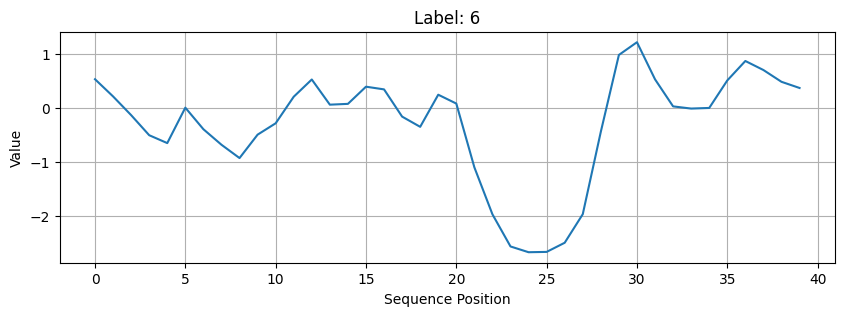

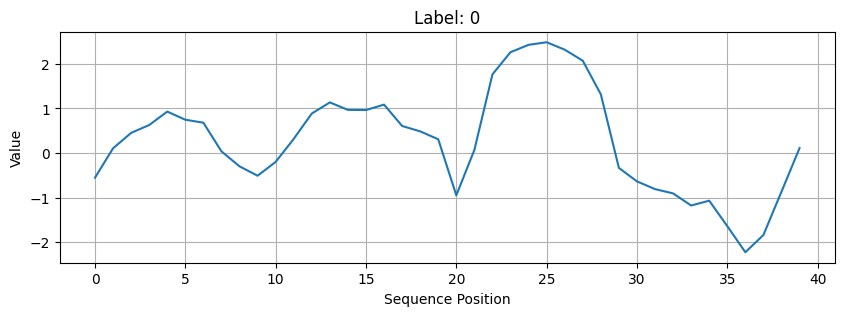

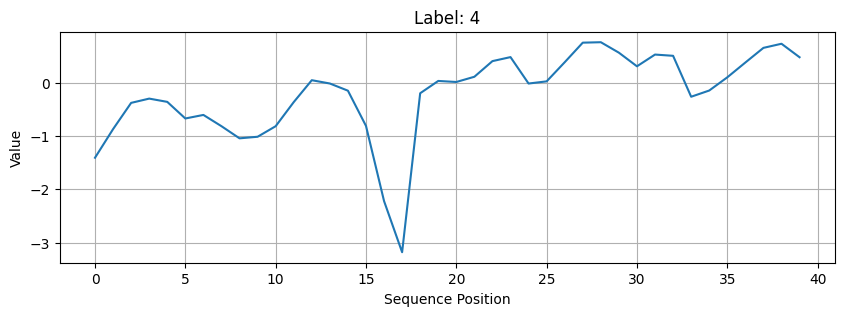

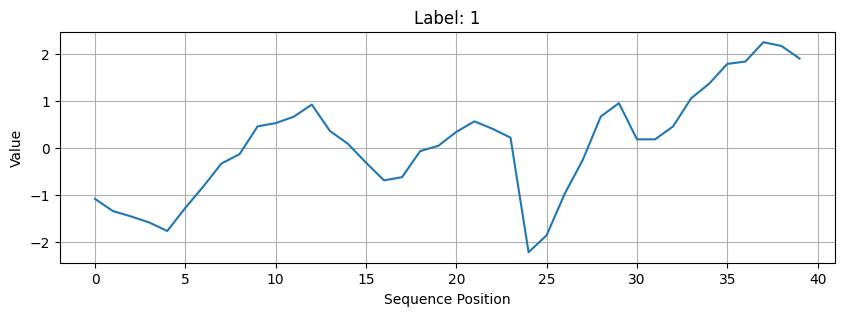

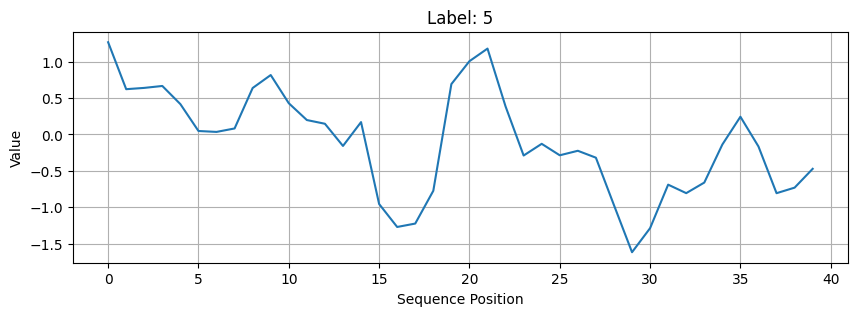

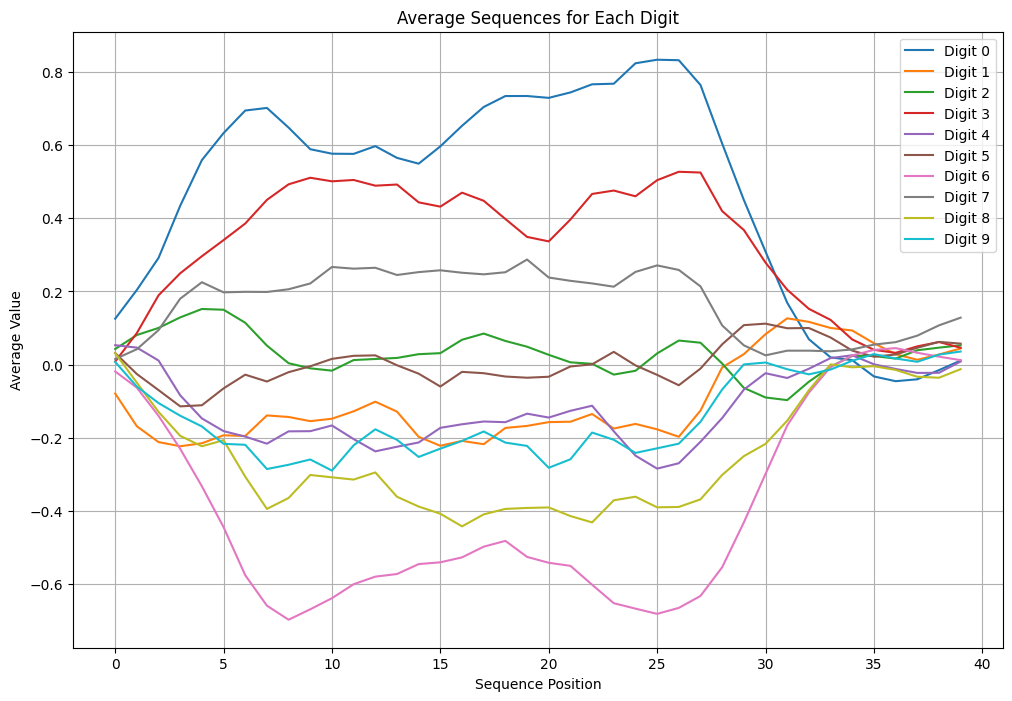

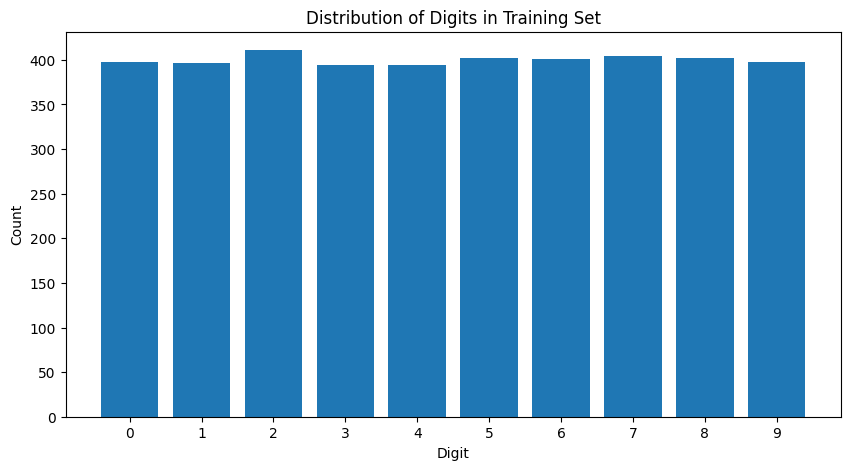

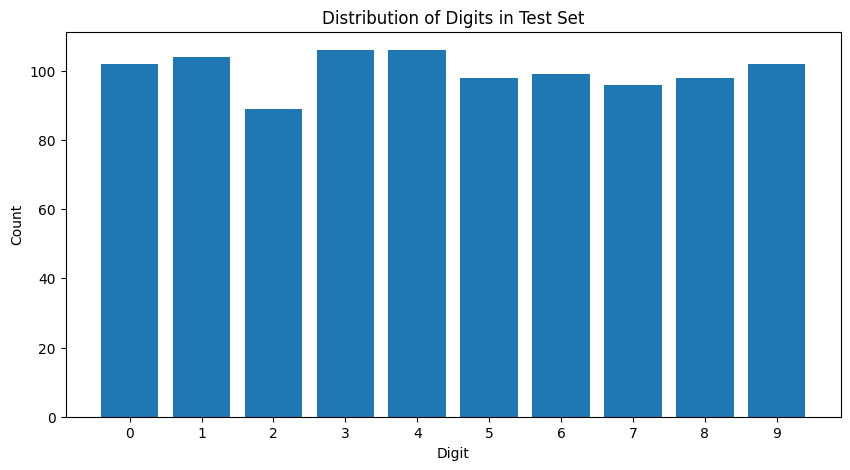

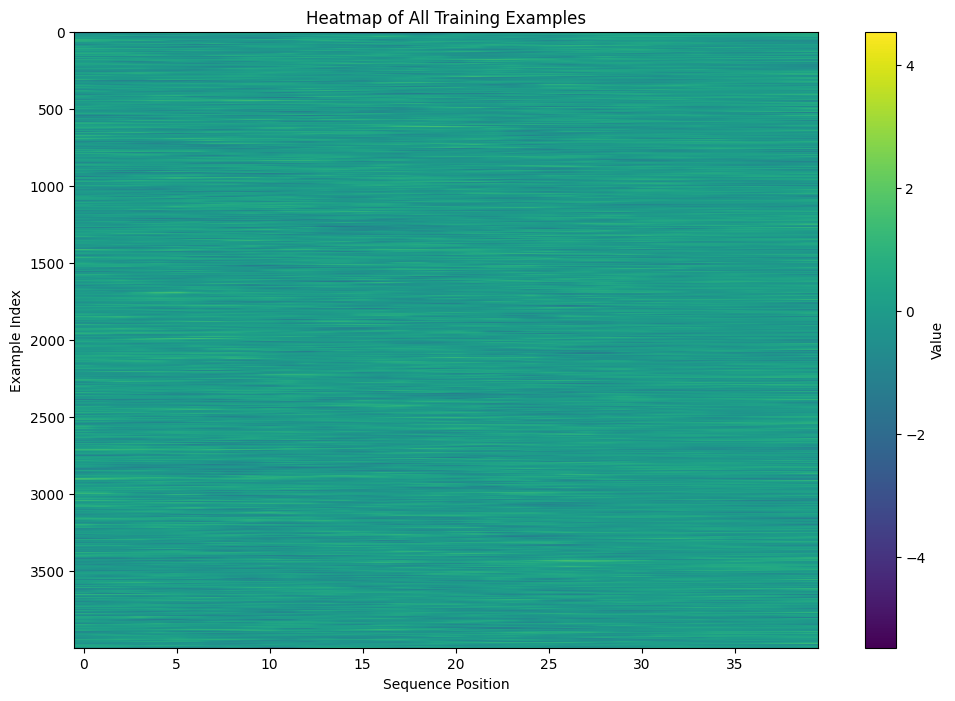

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Function to visualize a single example
def visualize_example(x, y, index):
    plt.figure(figsize=(10, 3))
    plt.plot(x[index])
    plt.title(f"Label: {y[index]}")
    plt.xlabel("Sequence Position")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

# Visualize a few examples from the training set
print("Visualizing 5 random examples from the training set:")
for i in np.random.choice(len(data['y']), 5, replace=False):
    visualize_example(data['x'], data['y'], i)

# Visualize average sequences for each digit
plt.figure(figsize=(12, 8))
for digit in range(10):
    digit_sequences = data['x'][data['y'] == digit]
    avg_sequence = np.mean(digit_sequences, axis=0)
    plt.plot(avg_sequence, label=f"Digit {digit}")

plt.title("Average Sequences for Each Digit")
plt.xlabel("Sequence Position")
plt.ylabel("Average Value")
plt.legend()
plt.grid(True)
plt.show()

# Visualize distribution of digits in training and test sets
def plot_digit_distribution(y, title):
    unique, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts)
    plt.title(title)
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.xticks(unique)
    plt.show()

plot_digit_distribution(data['y'], "Distribution of Digits in Training Set")
plot_digit_distribution(data['y_test'], "Distribution of Digits in Test Set")

# Visualize heatmap of all training examples
plt.figure(figsize=(12, 8))
plt.imshow(data['x'], aspect='auto', cmap='viridis')
plt.title("Heatmap of All Training Examples")
plt.xlabel("Sequence Position")
plt.ylabel("Example Index")
plt.colorbar(label="Value")
plt.show()

In [39]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
# model = torch.nn.Sequential(torch.nn.Linear(D_i, D_o));

# model = nn.Sequential(
#     nn.Linear(D_i, D_k),
#     nn.ReLU(),
#     nn.Linear(D_k, D_k),
#     nn.ReLU(),
#     nn.Linear(D_k, D_o)
# )

model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o)
)

def weights_init(layer_in):
    # Initialize the parameters with He initialization
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')
        if layer_in.bias is not None:
            nn.init.constant_(layer_in.bias, 0)


# Call the function you just defined
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)

Epoch     0, train loss 1.547933, train error 61.20,  test loss 1.606967, test error 63.80
Epoch     1, train loss 1.298064, train error 50.10,  test loss 1.458676, test error 58.70
Epoch     2, train loss 1.161317, train error 44.55,  test loss 1.360847, test error 53.90
Epoch     3, train loss 0.988888, train error 37.05,  test loss 1.250646, test error 48.20
Epoch     4, train loss 0.810033, train error 29.90,  test loss 1.155497, test error 44.90
Epoch     5, train loss 0.683102, train error 25.80,  test loss 1.093066, test error 39.30
Epoch     6, train loss 0.643136, train error 23.32,  test loss 1.130693, test error 40.90
Epoch     7, train loss 0.510757, train error 18.78,  test loss 1.113464, test error 40.90
Epoch     8, train loss 0.510657, train error 18.88,  test loss 1.144491, test error 39.00
Epoch     9, train loss 0.366061, train error 13.18,  test loss 1.049304, test error 35.90
Epoch    10, train loss 0.421288, train error 15.35,  test loss 1.171172, test error 37.90

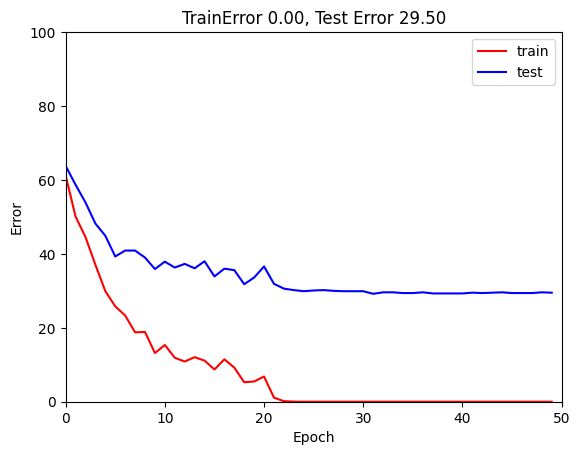

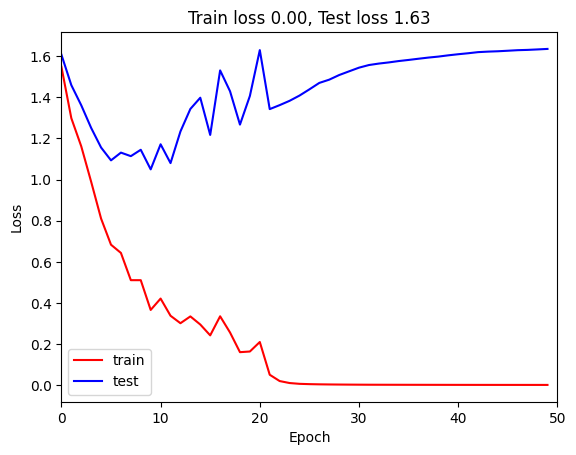

In [68]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9)
#adamw optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
# object that decreases learning rate by half every 10 epochs
#scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
#ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=125, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step(metrics=losses_test[epoch])


# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

#best result : 29.5% error rate

Improvements done below using lord gpt-3

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

In [52]:
# import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch.utils.data import DataLoader, TensorDataset
# import numpy as np
# import matplotlib.pyplot as plt

# # Adjust model architecture (if possible)
# # model = ...

# # Choose Adam optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Use ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# # Add L2 regularization
# weight_decay = 1e-5
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# # Prepare data loaders
# batch_size = 64  # Try different batch sizes
# train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size)

# # Training loop
# n_epochs = 100  # Increase number of epochs
# best_val_loss = float('inf')
# patience = 10
# epochs_no_improve = 0

# train_losses, val_losses = [], []

# for epoch in range(n_epochs):
#     model.train()
#     train_loss = 0.0
#     for batch in train_loader:
#         x_batch, y_batch = batch
#         optimizer.zero_grad()
#         outputs = model(x_batch)
#         loss = loss_function(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)
    
#     # Validation
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for batch in val_loader:
#             x_batch, y_batch = batch
#             outputs = model(x_batch)
#             loss = loss_function(outputs, y_batch)
#             val_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += y_batch.size(0)
#             correct += predicted.eq(y_batch).sum().item()
    
#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)
#     accuracy = 100 * correct / total
    
#     print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%')
    
#     # Learning rate scheduler step
#     scheduler.step(val_loss)
    
#     # Early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         epochs_no_improve = 0
#         torch.save(model.state_dict(), 'best_model.pth')
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve == patience:
#             print('Early stopping!')
#             break

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()